In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 1. 데이터 불러오기
try:
    train_df = pd.read_csv('../data/train.csv')
    test_df = pd.read_csv('../data/test.csv')
    submission_df = pd.read_csv('../data/sample_submission.csv')
except FileNotFoundError:
    print("파일 경로를 다시 확인해주세요.")
    exit()

# 2. 전처리 및 파생 변수 생성 함수
def preprocess_and_feature_engineer(df):
    df_processed = df.copy()
    
    if 'gender' in df_processed.columns:
        df_processed = df_processed.drop('gender', axis=1)

    df_processed.loc[df_processed['bone_density'] < 0, 'bone_density'] = 0
    df_processed[['medical_history', 'family_medical_history', 'edu_level']] = df_processed[['medical_history', 'family_medical_history', 'edu_level']].fillna('unknown')
    df_processed['mean_working'] = df_processed.groupby(['smoke_status', 'edu_level'])['mean_working'].transform(lambda x: x.fillna(x.median()))
    df_processed['mean_working'] = df_processed['mean_working'].fillna(df_processed['mean_working'].median())
    
    categorical_cols = ['activity', 'smoke_status', 'sleep_pattern',
                        'medical_history', 'family_medical_history', 'edu_level']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    df_processed['BMI'] = df_processed['weight'] / (df_processed['height'] / 100) ** 2
    df_processed['Pulse_Pressure'] = df_processed['systolic_blood_pressure'] - df_processed['diastolic_blood_pressure']
    df_processed['bp_interaction'] = df_processed['systolic_blood_pressure'] * df_processed['diastolic_blood_pressure']
    df_processed['cholesterol_glucose_ratio'] = df_processed['cholesterol'] / (df_processed['glucose'] + 1)
    
    return df_processed

# 3. 데이터에 함수 적용
train_final = preprocess_and_feature_engineer(train_df.copy())
test_final = preprocess_and_feature_engineer(test_df.copy())

# 4. 학습 데이터와 테스트 데이터의 컬럼 일치시키기
train_cols = set(train_final.columns)
test_cols = set(test_final.columns)
common_cols = list(train_cols.intersection(test_cols))
common_cols = [col for col in common_cols if col not in ['ID', 'stress_score']]

# 중요도가 낮은 변수 리스트 (제거)
low_importance_features = ['sleep_pattern_sleep difficulty', 'activity_moderate', 'mean_working']
final_cols = [col for col in common_cols if col not in low_importance_features]

# 5. K-Fold 교차 검증을 통한 RMSE 측정
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lgb_oof = np.zeros(len(train_final))
xgb_oof = np.zeros(len(train_final))

X_train_full = train_final[final_cols]
y_train_full = train_final['stress_score']

for fold, (train_index, val_index) in enumerate(kf.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    lgb_model = lgb.LGBMRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.1,
        num_leaves=40
    )
    lgb_model.fit(X_train, y_train)
    lgb_oof[val_index] = lgb_model.predict(X_val)

    xgb_model = xgb.XGBRegressor(
        random_state=42,
        n_estimators=500,
        learning_rate=0.1,
        max_depth=7,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    xgb_oof[val_index] = xgb_model.predict(X_val)

weight_lgb = 0.6
weight_xgb = 0.4
oof_predictions = (weight_lgb * lgb_oof) + (weight_xgb * xgb_oof)
oof_rmse = np.sqrt(mean_squared_error(y_train_full, oof_predictions))

print("---")
print(f"**교차 검증 RMSE 예상 점수**: {oof_rmse:.5f}")
print("---")

# 🌟🌟🌟 제출 파일 생성 🌟🌟🌟
# 최종 모델을 전체 학습 데이터로 다시 학습
final_lgb_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=300,
    learning_rate=0.1,
    num_leaves=40
)
final_lgb_model.fit(X_train_full, y_train_full)

final_xgb_model = xgb.XGBRegressor(
    random_state=42,
    n_estimators=500,
    learning_rate=0.1,
    max_depth=7,
    n_jobs=-1
)
final_xgb_model.fit(X_train_full, y_train_full)

# 테스트 데이터에 대한 예측
lgb_test_preds = final_lgb_model.predict(test_final[final_cols])
xgb_test_preds = final_xgb_model.predict(test_final[final_cols])

# 예측값 앙상블
final_predictions = (weight_lgb * lgb_test_preds) + (weight_xgb * xgb_test_preds)

# 제출 파일 생성
submission_df['stress_score'] = final_predictions
submission_df.to_csv('submission.csv', index=False)

print("submission.csv 파일 생성 완료!")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 25
[LightGBM] [Info] Start training from score 0.481912
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 25
[LightGBM] [Info] Start training from score 0.486092
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of test

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2282
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 20
[LightGBM] [Info] Start training from score 0.482130
### 현재 모델에 사용되는 전체 변수 중요도 순위 (내림차순) ###
                             feature  importance
                         cholesterol 1112.048737
                              height 1088.028848
                        bone_density 1080.058022
                              weight 1056.057303
                                 BMI 1027.059810
           cholesterol_glucose_ratio  974.061623
                             glucose  964.051703
                      bp_interaction  874.067620
                                 age  736.039305
                      Pulse_Pressure  723.057209


C:\Users\rladud\AppData\Local\Temp\ipykernel_10964\222162605.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=total_importance, palette='viridis')


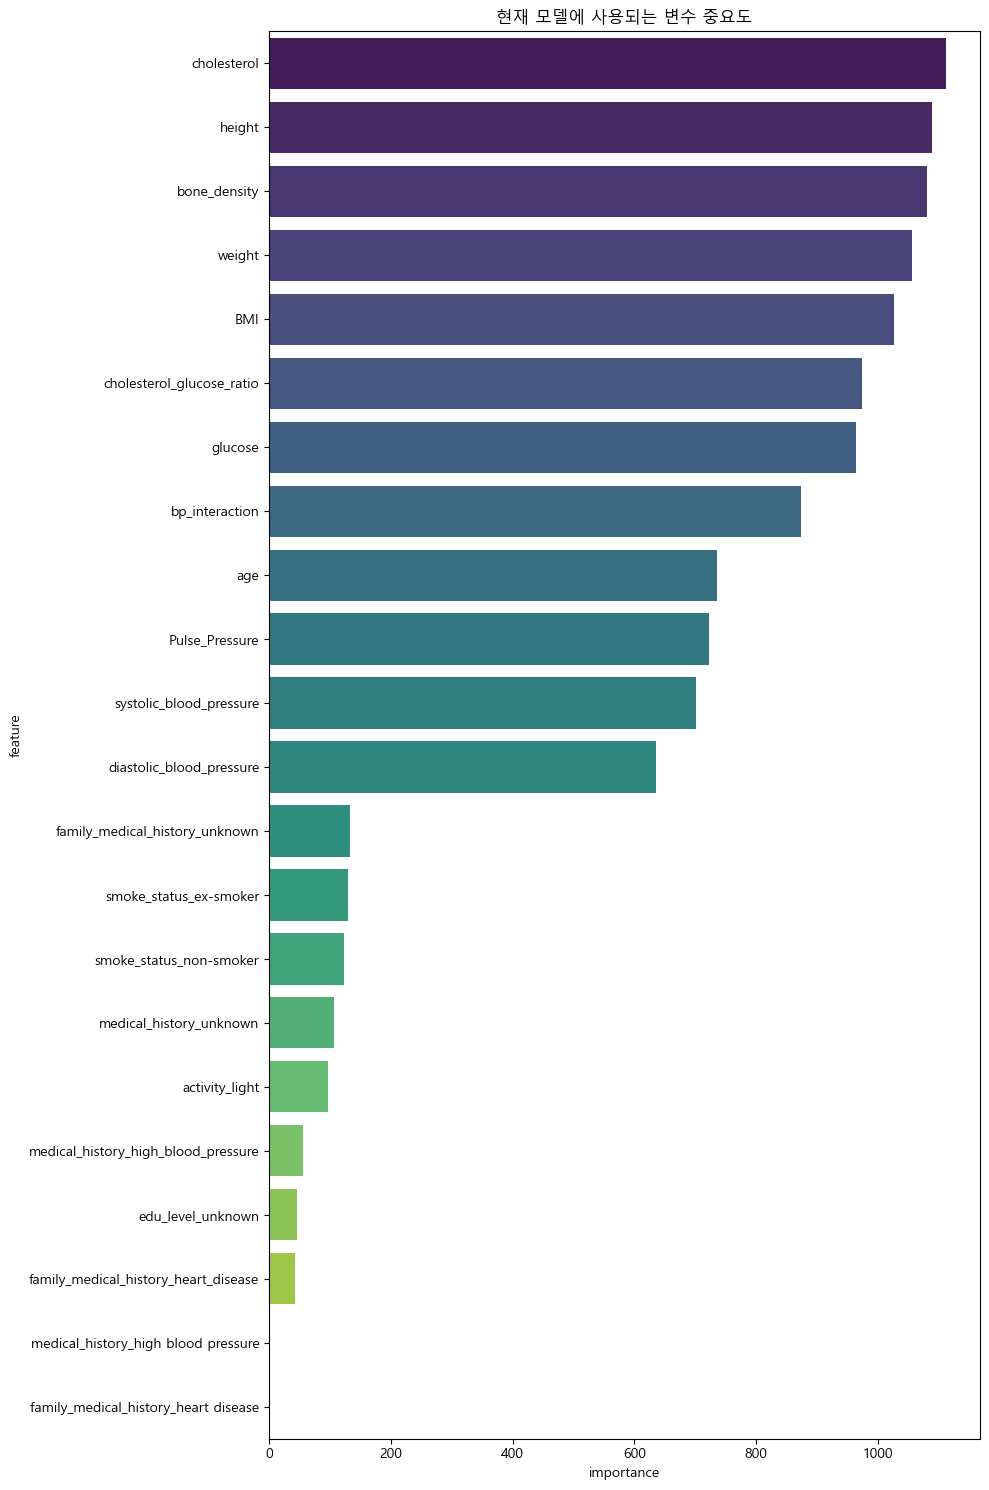

In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
try:
    train_df = pd.read_csv('../data/train.csv')
    test_df = pd.read_csv('../data/test.csv')
except FileNotFoundError:
    print("파일 경로를 다시 확인해주세요.")
    exit()

# 2. 전처리 및 파생 변수 생성 함수 (최종 버전)
def preprocess_and_feature_engineer(df):
    df_processed = df.copy()
    
    if 'gender' in df_processed.columns:
        df_processed = df_processed.drop('gender', axis=1)

    df_processed.loc[df_processed['bone_density'] < 0, 'bone_density'] = 0
    df_processed[['medical_history', 'family_medical_history', 'edu_level']] = df_processed[['medical_history', 'family_medical_history', 'edu_level']].fillna('unknown')
    df_processed['mean_working'] = df_processed.groupby(['smoke_status', 'edu_level'])['mean_working'].transform(lambda x: x.fillna(x.median()))
    df_processed['mean_working'] = df_processed['mean_working'].fillna(df_processed['mean_working'].median())
    
    categorical_cols = ['activity', 'smoke_status', 'sleep_pattern',
                        'medical_history', 'family_medical_history', 'edu_level']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    df_processed['BMI'] = df_processed['weight'] / (df_processed['height'] / 100) ** 2
    df_processed['Pulse_Pressure'] = df_processed['systolic_blood_pressure'] - df_processed['diastolic_blood_pressure']
    df_processed['bp_interaction'] = df_processed['systolic_blood_pressure'] * df_processed['diastolic_blood_pressure']
    df_processed['cholesterol_glucose_ratio'] = df_processed['cholesterol'] / (df_processed['glucose'] + 1)
    
    return df_processed

# 3. 데이터에 함수 적용
train_final = preprocess_and_feature_engineer(train_df.copy())
test_final = preprocess_and_feature_engineer(test_df.copy())

# 4. 학습 데이터와 테스트 데이터의 컬럼 일치시키기
train_cols = set(train_final.columns)
test_cols = set(test_final.columns)
common_cols = list(train_cols.intersection(test_cols))
common_cols = [col for col in common_cols if col not in ['ID', 'stress_score']]

# 🌟🌟🌟 중요도가 낮다고 판단되어 제거할 변수 리스트 🌟🌟🌟
low_importance_features = [
    'sleep_pattern_sleep difficulty', 'activity_moderate', 'mean_working', 
    'edu_level_high_school_diploma', 'edu_level_high school diploma', 'edu_level_graduate degree',
    'medical_history_heart disease', 'family_medical_history_high blood pressure', 'sleep_pattern_oversleeping'
]
final_cols = [col for col in common_cols if col not in low_importance_features]

X_train_full = train_final[final_cols]
y_train_full = train_final['stress_score']

# 5. 최종 모델 학습
lgb_model = lgb.LGBMRegressor(random_state=42, n_estimators=300, learning_rate=0.1, num_leaves=40)
lgb_model.fit(X_train_full, y_train_full)

xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.1, max_depth=7, n_jobs=-1)
xgb_model.fit(X_train_full, y_train_full)

# 6. 변수 중요도 추출 및 합산
lgb_importance = pd.DataFrame({'feature': lgb_model.feature_name_, 'importance': lgb_model.feature_importances_})
xgb_importance = pd.DataFrame({'feature': xgb_model.feature_names_in_, 'importance': xgb_model.feature_importances_})

total_importance = lgb_importance.set_index('feature').add(xgb_importance.set_index('feature'), fill_value=0).mean(axis=1).reset_index()
total_importance.columns = ['feature', 'importance']
total_importance = total_importance.sort_values(by='importance', ascending=False)

# 7. 변수 중요도 출력
print("### 현재 모델에 사용되는 전체 변수 중요도 순위 (내림차순) ###")
print(total_importance.to_string(index=False))

# 8. 변수 중요도 시각화
try:
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
except:
    print("한글 폰트 설정에 실패했습니다. 그래프에 한글이 깨져 보일 수 있습니다.")
    
plt.figure(figsize=(10, 15))
sns.barplot(x='importance', y='feature', data=total_importance, palette='viridis')
plt.title('현재 모델에 사용되는 변수 중요도')
plt.tight_layout()
plt.show()